In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
(xtrain, ytrain), (xtest, ytest) = keras.datasets.mnist.load_data()
xtrain, xtest = (x[:,:,:,np.newaxis]/255 for x in (xtrain, xtest))

In [3]:
X = X_input = keras.layers.Input((28,28,1))
X = keras.layers.Conv2D(16, (7,7), activation='relu', kernel_initializer='he_uniform')(X)
X = keras.layers.Conv2D(16, (7,7), activation='relu', kernel_initializer='he_uniform')(X)
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(10, activation='softmax')(X)
M = keras.Model(X_input, X)
M.compile('adam', 'sparse_categorical_crossentropy', ['acc'])
M_frezze = keras.Model(X_input, X)
M_frezze.trainable = False
M_frezze.compile('adam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 16)        800       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        12560     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                40970     
Total params: 54,330
Trainable params: 54,330
Non-trainable params: 0
_________________________________________________________________


In [4]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=64, epochs=5, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 16s 268us/step - loss: 0.1469 - acc: 0.9545 - val_loss: 0.0434 - val_acc: 0.9847
Epoch 2/5
60000/60000 [==============================] - 15s 251us/step - loss: 0.0488 - acc: 0.9848 - val_loss: 0.0394 - val_acc: 0.9864
Epoch 3/5
60000/60000 [==============================] - 14s 241us/step - loss: 0.0346 - acc: 0.9895 - val_loss: 0.0352 - val_acc: 0.9885
Epoch 4/5
60000/60000 [==============================] - 14s 238us/step - loss: 0.0265 - acc: 0.9915 - val_loss: 0.0440 - val_acc: 0.9866
Epoch 5/5
60000/60000 [==============================] - 15s 246us/step - loss: 0.0211 - acc: 0.9931 - val_loss: 0.0390 - val_acc: 0.9895


In [5]:
class BestInput(keras.layers.Layer):
    
    def __init__(self, regularizer=None, **kwargs):
        self.regularizer = regularizer
        super(BestInput, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.best_input = self.add_weight(
            shape=input_shape[1:],
            initializer='glorot_uniform', name='best_input',
            regularizer=self.regularizer,
            constraint=keras.constraints.non_neg())
        super(BestInput, self).build(input_shape)
    
    def call(self, inputs):
        x = inputs
        return x*self.best_input + (1-x)*K.stop_gradient(self.best_input)
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [29]:
def optimize_best_input(BI, X_BestInput, start_with_random_array=False, epochs=3000):
    plt.figure(figsize=(15,10))
    for target in range(10):
        for i in range(2):
            if start_with_random_array:
                X_BestInput.set_weights([np.random.random((28,28,1))])
            else:
                X_BestInput.set_weights([xtest[np.random.randint(0, len(xtest))]])
            BI.fit(np.ones((1,28,28,1)), keras.utils.to_categorical([target], 10), epochs=epochs, verbose=0)
            best_input = X_BestInput.get_weights()[0]
            best_input_pred = M.predict(best_input[np.newaxis,:,:,:])[0]
            plt.subplot(4,5,target*2+i+1)
            plt.title(f'predicted as {np.argmax(best_input_pred)} with {best_input_pred[np.argmax(best_input_pred)]:.3f}')
            plt.tick_params(labeltop=False, labelbottom=False, labelleft=False, labelright=False)
            plt.imshow(best_input[:,:,0])
            plt.colorbar()
    plt.show()

### optimize input with random initialization
- there are lots of "high entropy" input that can **fake/hack** the neural network to make it believe as a high confidence prediction

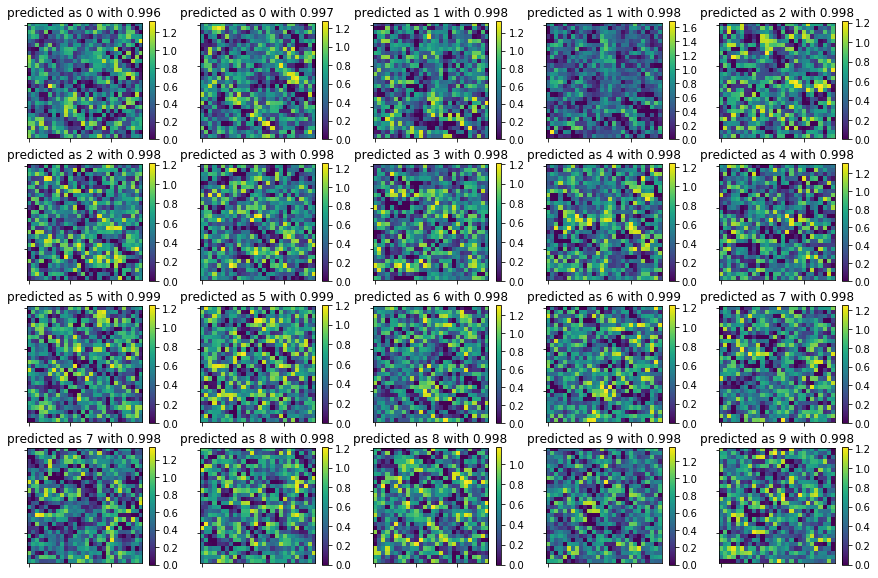

In [30]:
X = X_input = keras.layers.Input((28,28,1))
X_BestInput = BestInput()
X = X_BestInput(X)
X = M_frezze(X)
BI = keras.Model(X_input, X)
BI.compile('nadam', 'mse')
optimize_best_input(BI, X_BestInput, start_with_random_array=True)

### optimize input with random validation set datapoint as initialization
- there are lots of high condidence prediction that human can easily recognize as another digit
- if the original validation set datapoint is near perfect confidence to the neural network prediction, the input optimization simply don't work

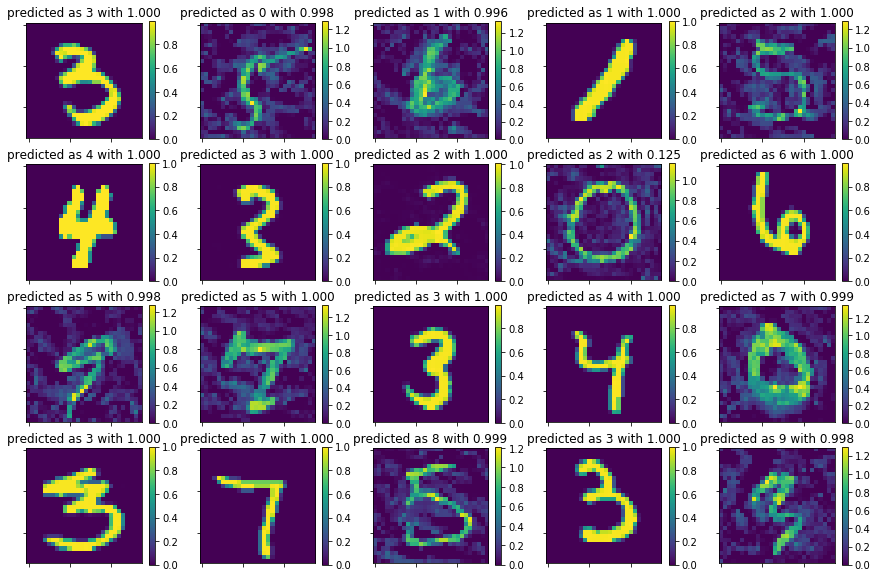

In [31]:
optimize_best_input(BI, X_BestInput, start_with_random_array=False)

### optimize input with random initialization and L1 penalty
- L1 penalty shows a activation of a few input can lead to middle confident prediction already, these points should be the inputs that comes with high fisher information to the target digit class

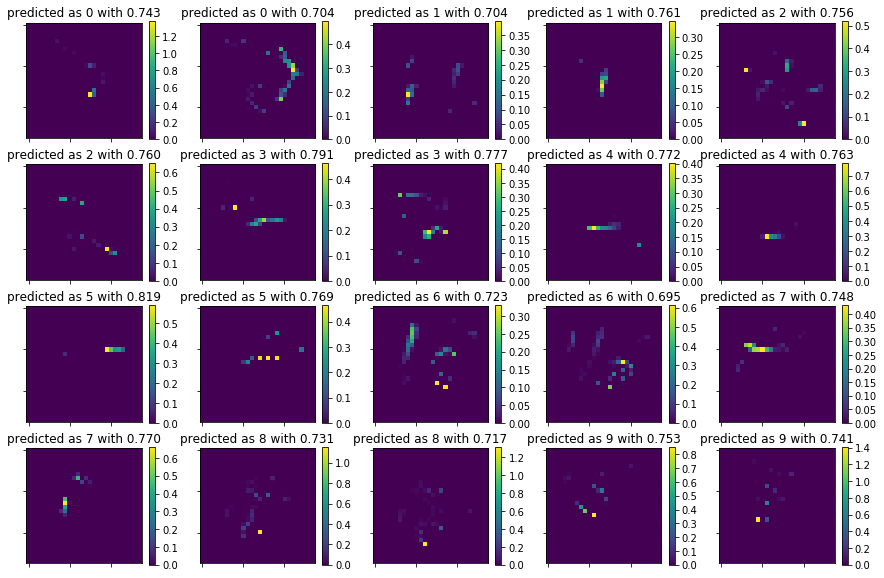

In [34]:
X = X_input = keras.layers.Input((28,28,1))
X_BestInput = BestInput(regularizer=keras.regularizers.l1())
X = X_BestInput(X)
X = M_frezze(X)
BI = keras.Model(X_input, X)
BI.compile('nadam', 'mse')
optimize_best_input(BI, X_BestInput, start_with_random_array=True)

### optimize input with random validation set datapoint as initialization and L1 penalty
- penalty can at lease mitigate the probem of in-optimizable input, even some input was initialized to near perfect prediction of another digit class

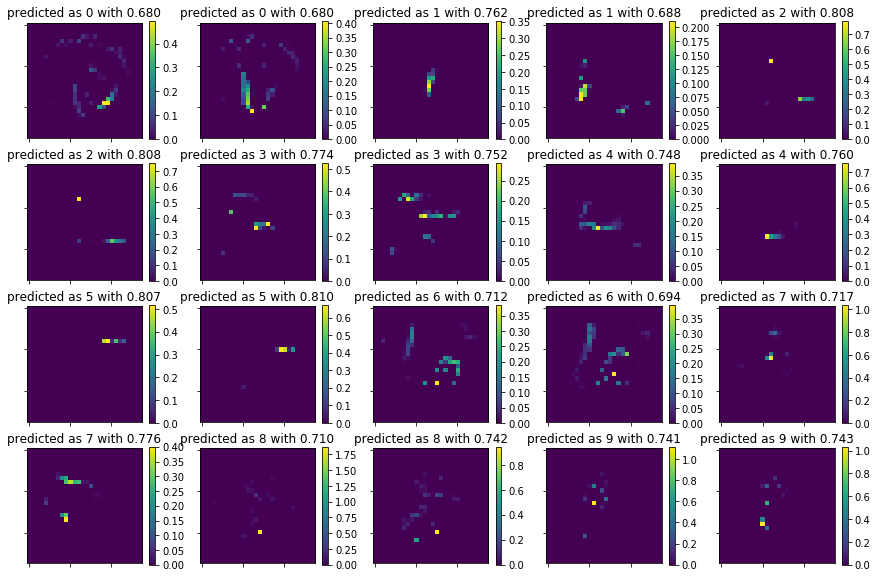

In [35]:
optimize_best_input(BI, X_BestInput, start_with_random_array=False)

### optimize input with random initialization and L2 penalty
- to optimize reasonable optimal input, L2 is important to remove random pixel input that has low fisher information to the target digit class

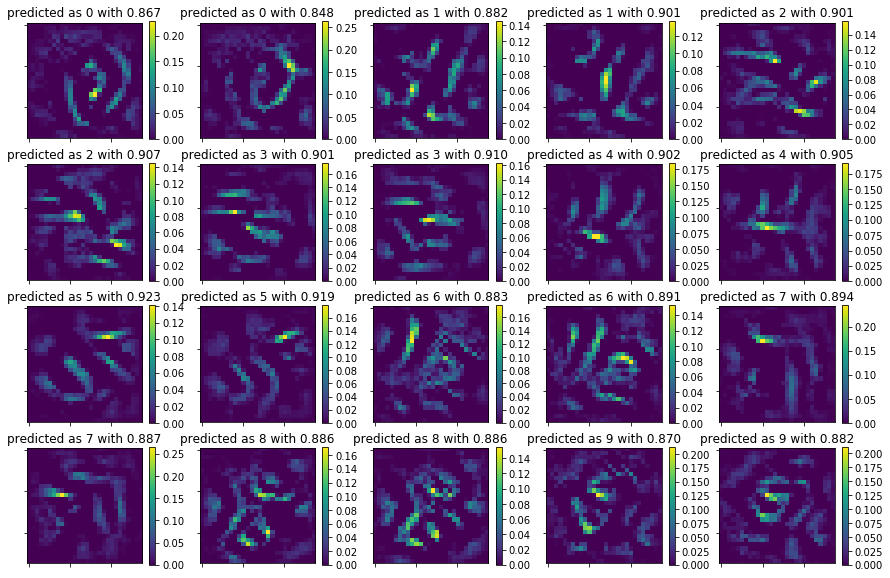

In [32]:
X = X_input = keras.layers.Input((28,28,1))
X_BestInput = BestInput(regularizer=keras.regularizers.l2())
X = X_BestInput(X)
X = M_frezze(X)
BI = keras.Model(X_input, X)
BI.compile('nadam', 'mse')
optimize_best_input(BI, X_BestInput, start_with_random_array=True)

### optimize input with random validation set datapoint as initialization and L2 penalty
- L2 penalty also mitigate the problem of, if the initial value of the input was a near perfect prediction of another digit class then the input will be not optimizable

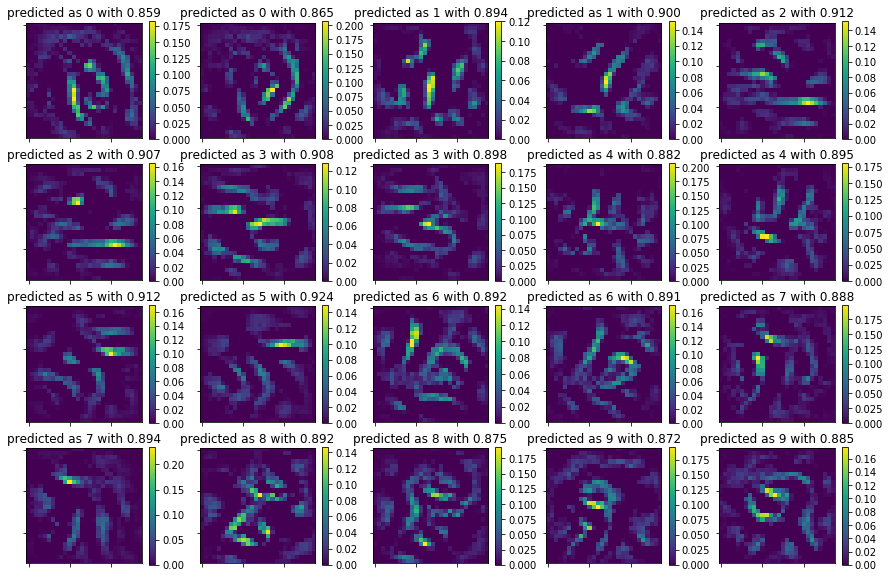

In [33]:
optimize_best_input(BI, X_BestInput, start_with_random_array=False)